## Monet Painting Notebook
https://github.com/dlytten/Painter-Repo.git

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets as KD
import matplotlib.pyplot as plt
import numpy as np
import PIL
import shutil
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
autoTone = tf.data.experimental.AUTOTUNE   
print(tf.__version__)

Number of replicas: 1
2.6.4


In [3]:
gcsPath = KD().get_gcs_path()
photoFilenames = tf.io.gfile.glob(str(gcsPath + '/photo_tfrec/*.tfrec'))
print('Photo tfRecord Files:', len(photoFilenames))

Photo tfRecord Files: 20


2022-12-08 06:42:01.817248: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [4]:
monetFilenames = tf.io.gfile.glob(str(gcsPath + '/monet_tfrec/*.tfrec'))
print('Monet tfRecord Files:', len(monetFilenames))

Monet tfRecord Files: 5


In [5]:
imgSize = [256, 256]

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    img = tf.reshape(img, [*imgSize, 3])
    return img

def read_tfrecord(exm):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    exm = tf.io.parse_single_example(exm, tfrecord_format)
    img = decode_image(exm['image'])
    return img

In [6]:
def load_dataset(fileNames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(fileNames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autoTone)
    return dataset

In [7]:
monetDs = load_dataset(monetFilenames, labeled=True).batch(1)
photoDs = load_dataset(photoFilenames, labeled=True).batch(1)
exmMonet = next(iter(monetDs))
exmPhoto = next(iter(photoDs))

2022-12-08 06:42:02.111248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 06:42:02.112346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 06:42:02.123548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 06:42:02.124459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 06:42:02.125267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [8]:
outputChannels = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gammaInit = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gammaInit))

    result.add(layers.LeakyReLU())

    return result

In [9]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gammaInit = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gammaInit))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [10]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    downStack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
    ]

    upStack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4), 
        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(outputChannels, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    
    skips = []
    
    for down in downStack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(upStack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [11]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gammaInit = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zeroPad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zeroPad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gammaInit)(conv)

    leakyRelu = layers.LeakyReLU()(norm1)

    zeroPad2 = layers.ZeroPadding2D()(leakyRelu) 

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zeroPad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [12]:
with strategy.scope():
    monetGenerator = Generator() 
    photoGenerator = Generator() 

    monetDiscriminator = Discriminator() 
    photoDiscriminator = Discriminator()

2022-12-08 06:42:08.530110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


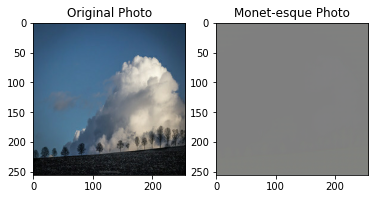

In [13]:
toMonet = monetGenerator(exmPhoto)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(exmPhoto[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(toMonet[0] * 0.5 + 0.5)
plt.show()

In [14]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monetGenerator,
        photoGenerator,
        monetDiscriminator,
        photoDiscriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monetGenerator
        self.p_gen = photoGenerator
        self.m_disc = monetDiscriminator
        self.p_disc = photoDiscriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [15]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [16]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [17]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
with strategy.scope():
    cycle_gan_model = CycleGan(
        monetGenerator, photoGenerator, monetDiscriminator, photoDiscriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )
    
cycle_gan_model.fit(
    tf.data.Dataset.zip((monetDs, photoDs)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 185s 467ms/step - monet_gen_loss: 5.0941 - photo_gen_loss: 5.3057 - monet_disc_loss: 0.6574 - photo_disc_loss: 0.6188
Epoch 2/25
300/300 [==============================] - 140s 467ms/step - monet_gen_loss: 3.6592 - photo_gen_loss: 3.7235 - monet_disc_loss: 0.6430 - photo_disc_loss: 0.6385
Epoch 3/25
300/300 [==============================] - 140s 465ms/step - monet_gen_loss: 3.6311 - photo_gen_loss: 3.6770 - monet_disc_loss: 0.6407 - photo_disc_loss: 0.6234
Epoch 4/25
300/300 [==============================] - 140s 466ms/step - monet_gen_loss: 3.5387 - photo_gen_loss: 3.5965 - monet_disc_loss: 0.6286 - photo_disc_loss: 0.6213
Epoch 5/25
300/300 [==============================] - 140s 465ms/step - monet_gen_loss: 3.3885 - photo_gen_loss: 3.4562 - monet_disc_loss: 0.6253 - photo_disc_loss: 0.6161
Epoch 6/25
300/300 [==============================] - 140s 464ms/step - monet_gen_loss: 3.2974 - photo_gen_loss: 3.3520 - monet_disc_loss: 0

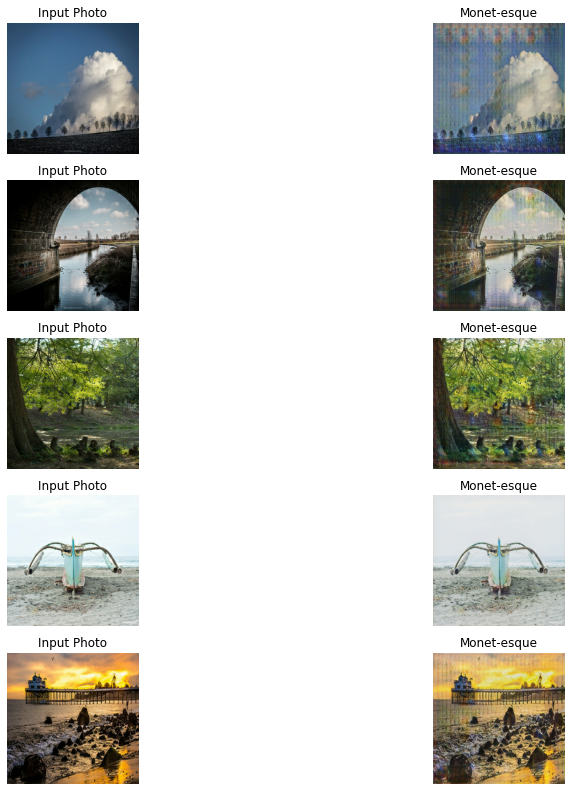

In [18]:
_, ax = plt.subplots(5, 2, figsize=(14, 14))
for i, img in enumerate(photoDs.take(5)):
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [19]:
! mkdir ../images
i = 1
for img in photoDs:
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'